In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Dropout, Flatten, concatenate, Input,GRU
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

/home/shetty61/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/shetty61/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/tmp/ipykernel_210406/3572549042.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-19 23:55:50.133264: E external/

In [2]:
df = pd.read_csv('/depot/lanhamm/project-smith/Test/sales1CA2_Melt_Calendar_OutTreat_LabelEnc.csv')

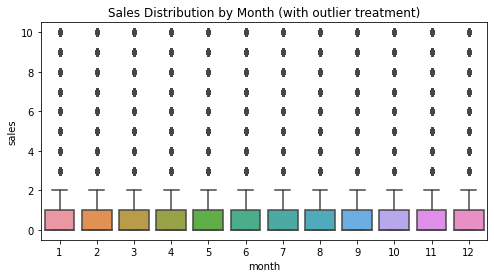

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,4))
sns.boxplot(data=df, x='month' , y='sales' )
ax.set_title('Sales Distribution by Month (with outlier treatment)')
plt. show()

In [6]:
df.columns

Index(['day', 'wday', 'month', 'year', 'item_id_enc', 'dept_id_enc',
       'store_id_enc', 'event_name_1_enc', 'event_type_1_enc',
       'event_name_1_enc.1', 'snap_CA', 'sales'],
      dtype='object')

In [10]:
# GRU
sequence_length = 28
sequences = []
categorical_data = []
numerical_data = []
targets = []

In [11]:
# Ensure the data is sorted if it's not already
df.sort_values(by=['day', 'year', 'month', 'wday', 'store_id_enc', 'dept_id_enc', 'item_id_enc', 'event_type_1_enc', 'event_name_1_enc', 'snap_CA'], inplace=True)

# Group by the categorical variables
grouped = df.groupby(['store_id_enc', 'dept_id_enc', 'item_id_enc', 'event_type_1_enc', 'event_name_1_enc'])

In [12]:
for _, group in grouped:
    sales = group['sales'].values
    
    # Convert necessary columns to numpy arrays
    store_ids = group['store_id_enc'].values
    dept_ids = group['dept_id_enc'].values
    item_ids = group['item_id_enc'].values
    events = group['event_name_1_enc'].values
    evtype = group['event_type_1_enc'].values
    
    # New: Numerical features
    days = group['day'].values
    years = group['year'].values
    months = group['month'].values
    wd = group['wday'].values
    snap_CA = group['snap_CA'].values
    
    for i in range(len(sales) - sequence_length):
        sequences.append(sales[i:i+sequence_length])
        targets.append(sales[i+sequence_length])
        categorical_data.append([store_ids[i], dept_ids[i], item_ids[i], events[i], evtype[i]])
        # Include numerical features
        numerical_data.append([days[i], years[i], months[i], wd[i], snap_CA[i]])

In [13]:
# Convert to numpy arrays
sequences = np.array(sequences)
targets = np.array(targets)
categorical_data = np.array(categorical_data)
numerical_data = np.array(numerical_data)

# Split data into train and test sets
X_train_sequences, X_test_sequences, y_train, y_test, X_train_categorical, X_test_categorical, X_train_numerical, X_test_numerical = train_test_split(sequences, targets, categorical_data, numerical_data, test_size=0.2, random_state=42)


In [14]:
# Reshape input for LSTM
X_train_sequences = X_train_sequences.reshape((X_train_sequences.shape[0], X_train_sequences.shape[1], 1))
X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], X_test_sequences.shape[1], 1))

In [15]:
# Define model inputs for categorical variables

embedding_dim = 10  # Reduced embedding dimension

input_item = Input(shape=(1,))
embed_item = Embedding(input_dim=np.max(df['item_id_enc'])+1, output_dim=embedding_dim)(input_item)
flat_item = Flatten()(embed_item)

input_dept = Input(shape=(1,))
embed_dept = Embedding(input_dim=np.max(df['dept_id_enc'])+1, output_dim=embedding_dim)(input_dept)
flat_dept = Flatten()(embed_dept)

input_store = Input(shape=(1,))
embed_store = Embedding(input_dim=np.max(df['store_id_enc'])+1, output_dim=embedding_dim)(input_store)
flat_store = Flatten()(embed_store)

input_event = Input(shape=(1,))
embed_event = Embedding(input_dim=np.max(df['event_name_1_enc'])+1, output_dim=embedding_dim)(input_event)
flat_event = Flatten()(embed_event)

input_evtype = Input(shape=(1,))
embed_evtype = Embedding(input_dim=np.max(df['event_type_1_enc'])+1, output_dim=embedding_dim)(input_evtype)
flat_evtype = Flatten()(embed_evtype)

input_numerical = Input(shape=(5,))  # Adjust shape based on the number of numerical features

2024-02-19 23:58:56.385202: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
# Define model input for the sales sequences
input_sequences = Input(shape=(sequence_length, 1))

# GRU layer for processing sequences
gru_out = GRU(50)(input_sequences)  # Using GRU instead of LSTM

# Concatenate GRU output with flattened embeddings
concat = concatenate([flat_store, flat_dept, flat_item, flat_event, flat_evtype, gru_out, input_numerical])

# Output layer
output = Dense(1)(concat)

In [17]:
# Create and compile model
model = Model(inputs=[input_store, input_dept, input_item, input_event, input_evtype, input_sequences, input_numerical], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
model.fit(
    [X_train_categorical[:, 0], X_train_categorical[:, 1], X_train_categorical[:, 2], X_train_categorical[:, 3], X_train_categorical[:, 4], X_train_sequences, X_train_numerical],
    y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/20
36248/36248 [==============================] - 618s 17ms/step - loss: 476.1165 - val_loss: 1.6969
Epoch 2/20
36248/36248 [==============================] - 618s 17ms/step - loss: 1.1650 - val_loss: 1.2915
Epoch 3/20
36248/36248 [==============================] - 615s 17ms/step - loss: 1.1565 - val_loss: 1.2602
Epoch 4/20
 7837/36248 [=====>........................] - ETA: 7:26 - loss: 1.1525

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36248/36248 [==============================] - 615s 17ms/step - loss: 1.1523 - val_loss: 1.0925
Epoch 5/20
36248/36248 [==============================] - 611s 17ms/step - loss: 1.1522 - val_loss: 1.0833
Epoch 6/20
36248/36248 [==============================] - 616s 17ms/step - loss: 1.1504 - val_loss: 1.1800
Epoch 7/20
36248/36248 [==============================] - 608s 17ms/step - loss: 1.1483 - val_loss: 1.2767
Epoch 8/20
36248/36248 [==============================] - 615s 17ms/step - loss: 1.1485 - val_loss: 1.1036
Epoch 9/20
36248/36248 [==============================] - 584s 16ms/step - loss: 1.1499 - val_loss: 1.5220
Epoch 10/20
36248/36248 [==============================] - 586s 16ms/step - loss: 1.1494 - val_loss: 1.0966
Epoch 11/20
36248/36248 [==============================] - 584s 16ms/step - loss: 1.1470 - val_loss: 1.1865


In [20]:
# Predict on the test set
y_pred = model.predict([X_test_categorical[:, 0], X_test_categorical[:, 1], X_test_categorical[:, 2], X_test_categorical[:, 3], X_test_categorical[:, 4], X_test_sequences, X_test_numerical])

# Evaluate the model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error
rmse = math.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

45309/45309 [==============================] - 134s 3ms/step
Mean Squared Error (MSE): 1.1845395033013113
Root Mean Squared Error (RMSE): 1.0883655191622488


In [21]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.777317311470266
R-squared (R²): 0.5574093980041236
